In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('data/predictive_maintenance.csv')

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [9]:
TARGET_COL = 'Machine failure'

In [10]:
# Calculate the failure rate
failure_rate = df[TARGET_COL].mean()

In [12]:
print(f"Percentage of 'No Failure' (Class 0): {100 * (1 - failure_rate):.1f}%")
print(f"Percentage of 'Failure' (Class 1): {100 * failure_rate:.1f}%")

Percentage of 'No Failure' (Class 0): 96.6%
Percentage of 'Failure' (Class 1): 3.4%


In [15]:
sns.set_style('whitegrid')

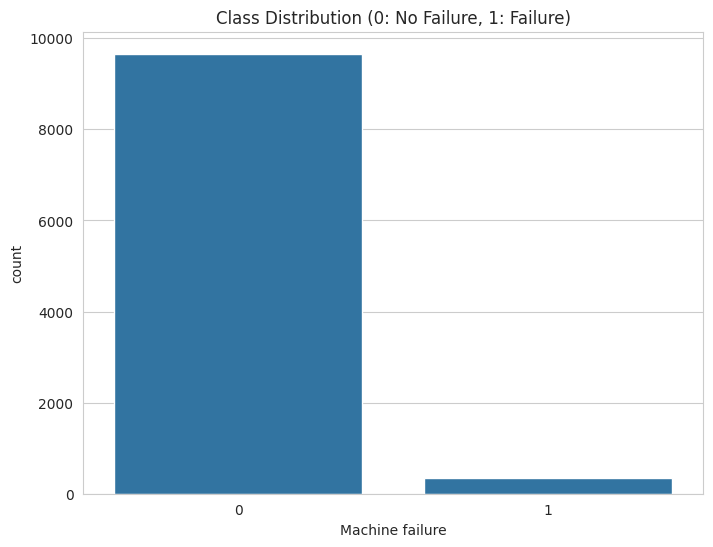

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x=TARGET_COL, data=df)
plt.title('Class Distribution (0: No Failure, 1: Failure)')
plt.show()

In [23]:
features_to_drop = [
    'UDI',
    'Product ID',
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
]

X = df.drop(columns=[TARGET_COL] + features_to_drop)
y = df[TARGET_COL]

In [24]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Successfully defined feature lists:")
print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Successfully defined feature lists:
Categorical Features: ['Type']
Numerical Features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [25]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (8000, 6)
Test set shape: (2000, 6)


In [29]:
# Preprocessing Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [30]:
# transformer for numerical features (scaling)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [33]:
# Build, Train, and Evaluate Models

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [34]:
# --- Model 1: Logistic Regression (a simple baseline) ---
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(random_state=42))])

In [36]:
# --- Model 2: Random Forest (a more powerful model) ---
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])

In [37]:
# --- Model 3: Random Forest with Class Weighting (our main contender) ---
pipe_rf_balanced = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])

In [44]:
# --- Train and Evaluate ---
models = {
    "Logistic Regression": pipe_lr,
    "Random Forest (Default)": pipe_rf,
    "Random Forest (Balanced)": pipe_rf_balanced
}

for name, model in models.items():
    print(f"--- {name} ---")
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Print the classification report
    print(classification_report(y_test, y_pred, target_names=['No Failure (0)', 'Failure (1)']))
    print("\n" + "="*50 + "\n")

--- Logistic Regression ---
                precision    recall  f1-score   support

No Failure (0)       0.97      1.00      0.98      1932
   Failure (1)       0.64      0.10      0.18        68

      accuracy                           0.97      2000
     macro avg       0.80      0.55      0.58      2000
  weighted avg       0.96      0.97      0.96      2000



--- Random Forest (Default) ---
                precision    recall  f1-score   support

No Failure (0)       0.98      1.00      0.99      1932
   Failure (1)       0.89      0.49      0.63        68

      accuracy                           0.98      2000
     macro avg       0.94      0.74      0.81      2000
  weighted avg       0.98      0.98      0.98      2000



--- Random Forest (Balanced) ---
                precision    recall  f1-score   support

No Failure (0)       0.98      1.00      0.99      1932
   Failure (1)       0.97      0.43      0.59        68

      accuracy                           0.98      2000

In [42]:
# RESULT: The Random Forest (Default) model gives us the best performance for our business case. It has the highest recall (49%) for the failure class, meaning it catches the most failures. It also has the highest F1-score (0.63), indicating the best overall balance.